In [149]:
import torch
from transformers import AutoModel, AutoTokenizer 

bertweet = AutoModel.from_pretrained("vinai/bertweet-large")

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", normalization=True)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

In [150]:
import pandas as pd

df = pd.read_csv('data/CSVs/Created/tweet_data.csv')
df.head()

,tweet_id,tweet_id.1,screen_name,time_posted,content,flagged,ari
0,329,780,jjujulangkey,2019-08-18 21:21:00,If you ride with Uber your life is in danger h...,1,0
1,999,67,Destiiny03,2018-04-17 21:40:26,This is why I’m single 🙃,0,0
2,1008,76,Destiiny03,2018-04-16 17:30:36,Guy*him* https://t.co/T33hFPkXEp,0,0
3,1296,25,SOSA_CB_,2018-06-05 11:49:26,@TGodfrey93 @Tsmackthebarber @MyOpini97849657 ...,0,0
4,737,6,kbreed89,2018-01-08 18:25:38,“Don’t ask questions-that was the first rule f...,0,0


In [152]:
embeddings = []

for line in df['content']:

    input_ids = torch.tensor([tokenizer.encode(line)])

    with torch.no_grad():
        features = bertweet(input_ids) 

    embeddings.append(features[1].numpy().flatten())

In [153]:
df['embedding'] = embeddings

In [154]:
print(df['embedding'][600])

[ 0.48507404  0.24088958  0.3513569  ...  0.29392636 -0.31329703
  0.23675078]


In [155]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
n_components = 2
tsne = TSNE(n_components,random_state=42)
tsne_vecs = tsne.fit_transform(embeddings)
df['tsne_vecs'] = list(tsne_vecs)
df.head()

/Users/arijitsen/opt/anaconda3/envs/anlp_spacy2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/arijitsen/opt/anaconda3/envs/anlp_spacy2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,tweet_id,tweet_id.1,screen_name,time_posted,content,flagged,ari,embedding,tsne_vecs
0,329,780,jjujulangkey,2019-08-18 21:21:00,If you ride with Uber your life is in danger h...,1,0,"[0.54635847, 0.41147226, 0.5099479, 0.24854745...","[-34.49366, -11.775466]"
1,999,67,Destiiny03,2018-04-17 21:40:26,This is why I’m single 🙃,0,0,"[0.63745064, 0.41161934, 0.41224667, 0.3274924...","[2.3580432, -5.448485]"
2,1008,76,Destiiny03,2018-04-16 17:30:36,Guy*him* https://t.co/T33hFPkXEp,0,0,"[0.6038625, 0.4200752, 0.4475878, 0.29988253, ...","[49.42142, 14.3946]"
3,1296,25,SOSA_CB_,2018-06-05 11:49:26,@TGodfrey93 @Tsmackthebarber @MyOpini97849657 ...,0,0,"[0.40101597, 0.33415607, 0.2867057, 0.28074136...","[10.386163, 44.008545]"
4,737,6,kbreed89,2018-01-08 18:25:38,“Don’t ask questions-that was the first rule f...,0,0,"[0.2974913, 0.22217545, 0.30430984, 0.22759299...","[0.5829976, 28.239286]"


In [156]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(embeddings)
df['cluster'] = list(kmeans.labels_)

In [184]:
import plotly.express as px

x = []
y = []
for i in range(0, len(tsne_vecs)): 
    x.append(tsne_vecs[i][0])
    y.append(tsne_vecs[i][1])

df['dim1'] = x 
df['dim2'] = y
df['cluster'] = df['cluster'].astype(str)

fig = px.scatter(df, x='dim1', y='dim2', color='cluster', hover_data=['content'], template='simple_white', color_discrete_map={
                "0": "#1F77B4",
                "1": "#FF7F0E"})
fig.show()
fig.write_html('cluster.html')

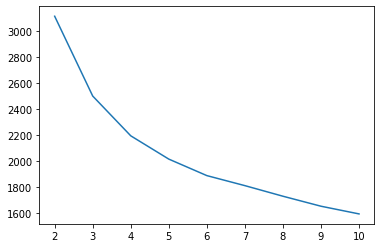

In [163]:
wcss=[]
for i in range(2, 11):
    kmeans1 = KMeans(n_clusters=i, random_state=42)
    kmeans1.fit(embeddings)
    wcss.append(kmeans1.inertia_)

from  matplotlib import pyplot as plt
plt.plot(range(2,11), wcss)
plt.show()

In [183]:
df['flagged'] = df ['flagged'].astype(str)
fig2 = px.scatter(df, x='dim1', y='dim2', color='flagged', hover_data=['content'], template='simple_white', color_discrete_map={
                "0": "#1F77B4",
                "1": "#FF7F0E"})
fig2.show()
fig2.write_html('ssi.html')

In [185]:
df['ari'] = df['ari'].astype(str)
fig3 = px.scatter(df, x='dim1', y='dim2', color='ari', hover_data=['content'], template='simple_white', color_discrete_map={
                "0": "#1F77B4",
                "1": "#FF7F0E"})
fig3.show()
fig3.write_html('ari.html')

In [196]:
from sklearn.metrics import accuracy_score
from  sklearn.metrics import precision_score
from sklearn.metrics  import recall_score
print(accuracy_score(df['ari'], df['flagged']))
print(precision_score(df['ari'], df['flagged'], pos_label='1'))
print(recall_score(df['ari'], df['flagged'], pos_label='1'))

0.6957928802588996
0.06516290726817042
0.896551724137931


In [195]:
print(accuracy_score(df['ari'], df['cluster']))
print(precision_score(df['ari'], df['cluster'], pos_label='1'))
print(recall_score(df['ari'], df['cluster'], pos_label='1'))

0.5736245954692557
0.01744186046511628
0.3103448275862069


In [198]:
len(df.loc[df['flagged'] == '1'])

399